In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import datetime as dt

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [8]:
model_names = [

    "mvo_ls_small_sample_cbb_cbb", "mvo_ls_small_sample_mle_mle"

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [9]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [10]:
all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
mvo_ls_small_sample_cbb_cbb,-0.951243,3.413581,-0.278664,-0.363558,-5.225289,-13.614571,0.474766
mvo_ls_small_sample_mle_mle,-33.328046,26.632649,-1.251398,-1.345190,-43.107023,-80.863186,0.473832


## 2) Cummulative Returns of the Portfolios

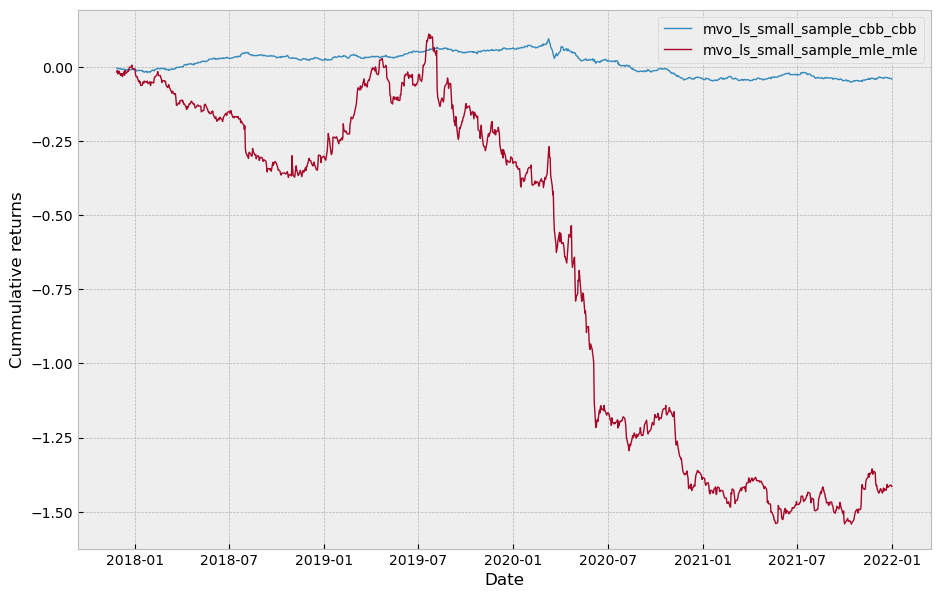

In [11]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2014-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [12]:
check_name = "mvo_ls_small_sample_cbb_cbb"
all_summary_df.loc[(all_summary_df["model"] == check_name), ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,148730.000000,1.487300e+05,1.487300e+05
mean,0.000591,1.628146e-12,-2.715665e-07
std,0.026220,8.312292e-03,2.169213e-04
min,-0.680769,-2.250183e-02,-9.597246e-03
25%,-0.008045,-7.169926e-03,-4.763931e-05
50%,0.000000,-5.981511e-05,0.000000e+00
75%,0.009249,7.175323e-03,4.854959e-05
max,0.939655,2.491899e-02,8.795375e-03


In [14]:
check_name = "mvo_ls_small_sample_mle_mle"
all_summary_df.loc[(all_summary_df["model"] == check_name), ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,148730.000000,1.487300e+05,1.487300e+05
mean,0.000591,3.548411e-12,-9.514687e-06
std,0.026220,3.032363e-02,1.471691e-03
min,-0.680769,-4.145369e-01,-1.163252e-01
25%,-0.008045,-3.745644e-05,-3.559651e-07
50%,0.000000,6.034432e-06,0.000000e+00
75%,0.009249,6.614007e-05,3.813501e-07
max,0.939655,3.332167e-01,6.872256e-02


In [8]:
all_summary_df.loc[all_summary_df["model"] == check_name, ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,293707.000000,293707.000000,293707.000000
mean,0.000493,0.372086,0.000179
std,0.022446,0.342769,0.011102
min,-0.680769,-1.000000,-0.379055
25%,-0.007158,0.023642,-0.001280
50%,0.000000,0.335464,0.000000
75%,0.008268,0.669295,0.001748
max,0.939655,1.000000,0.915776


<Axes: title={'center': 'AA returns'}, xlabel='date'>

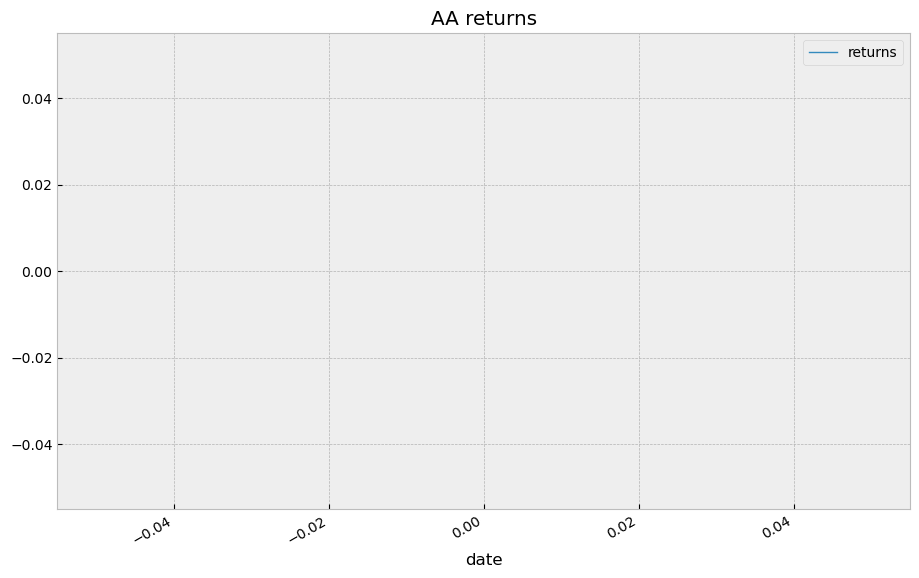

In [9]:
stock_name = "AA"

check_stock_df = all_summary_df.loc[(all_summary_df["model"] == check_name)&(all_summary_df["ticker"] == stock_name)][["date", "returns"]]
check_stock_df["date"] = pd.to_datetime(check_stock_df["date"])
check_stock_df.set_index("date", inplace=True)

check_stock_df.plot(figsize=(11, 7), title="{} returns".format(stock_name))

## 4) Check Returns from Raw Data

In [10]:
d1 = "2016-10-05"
d2 = "2016-10-06"

f1 = os.path.join(os.getcwd(), os.getcwd(), "data", "inputs", "US_CRSP_NYSE", "2016", "{}.csv.gz".format(d1).replace("-", ""))
f2 = os.path.join(os.getcwd(), os.getcwd(), "data", "inputs", "US_CRSP_NYSE", "2016", "{}.csv.gz".format(d2).replace("-", ""))
stock_name = "AA"

tmp_df1 = pd.read_csv(f1, compression='gzip', on_bad_lines='skip')
tmp_df2 = pd.read_csv(f2, compression='gzip', on_bad_lines='skip')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danieloliveira/Documents/Daniel/codes/rpowbe/src/data/inputs/US_CRSP_NYSE/2016/20161005.csv.gz'

In [20]:
tmp_df1.loc[tmp_df1["ticker"] == stock_name]

,Unnamed: 0,ticker,open,high,low,close,volume,OPCL,pvCLCL,prevAdjClose,SPpvCLCL,sharesOut,PERMNO,SICCD,PERMCO,prevRawOpen,prevRawClose,prevAdjOpen
15,16,AA,10.25,10.41,10.17,10.4,29736798,0.014528,0.019608,10.2,0.004297,1315380,24643,3334,20060,10.06,10.2,10.06


In [21]:
tmp_df2.loc[tmp_df2["ticker"] == stock_name]

,Unnamed: 0,ticker,open,high,low,close,volume,OPCL,pvCLCL,prevAdjClose,SPpvCLCL,sharesOut,PERMNO,SICCD,PERMCO,prevRawOpen,prevRawClose,prevAdjOpen
15,16,AA,31.07,32.02,31.07,31.78,10026484,0.022594,0.01859,31.2,0.000482,438460,24643,3334,20060,10.25,10.4,30.75
